# Processing Aguirre 2017
- Processing genomewide screen from [Aguirre et. al. 2017](https://cancerdiscovery.aacrjournals.org/content/6/8/914.long)
- Exons: For each gene, we excluded the first and last exons and any exon that
contained an alternative splicing site. Using these procedures, we chose 4 constitutive
exons for each gene.
- sgRNA design: Candidate sgRNAs with higher values of Sguide are predicted to have less off-target
activity.
For each gene, we chose 6 sgRNAs with the highest values of Sguide across all 4
constitutive exons (from step (1) ) subject to constraint that no more than 2 sgRNAs
could target a single exon.

### Data Filters
1. sgRNAs targetting essential genes
2. Match bin 1, tier 1 score of 0

In [1]:
import pandas as pd
import gpplot
import seaborn as sns
import matplotlib.pyplot as plt
import poola.core as pool

In [2]:
lfc_df = (pd.read_csv('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/depmap-data/guide_QCed.csv')
          .rename({'Unnamed: 0': 'sgRNA Sequence'}, axis = 1))
essential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/essential-genes-Hart2015.txt',
                                names=['GENE'])
nonessential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/non-essential-genes-Hart2014.txt',
                                   names=['GENE'])

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


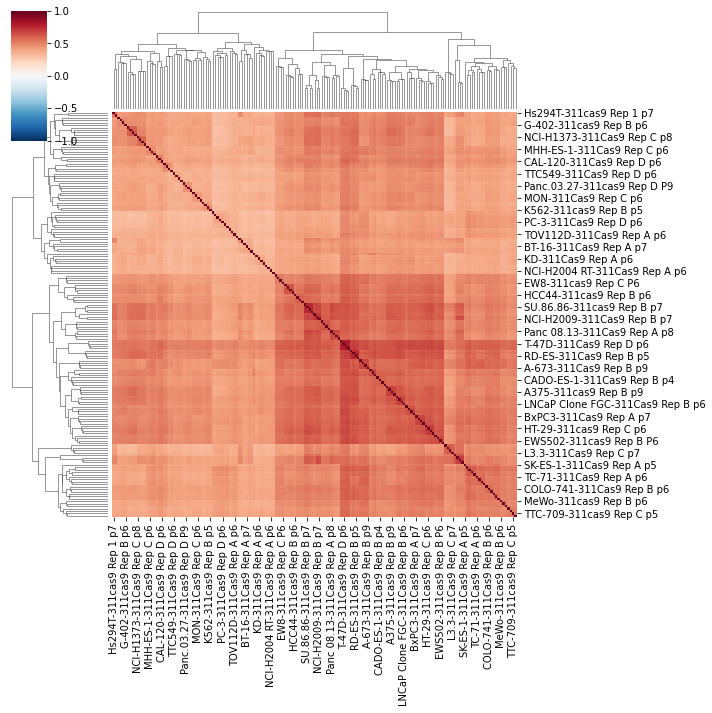

In [3]:
lfc_cors = lfc_df.corr()
sns.clustermap(lfc_cors, cmap='RdBu_r', vmin=-1, vmax=1)

In [4]:
long_cors = (lfc_cors.reset_index()
             .rename({'index': 'condition A rep'}, axis=1)
             .melt(var_name='condition B rep', value_name='pearson', id_vars='condition A rep'))
long_cors['condition A'] = long_cors['condition A rep'].str.split(' ', expand=True)[0]
long_cors['condition B'] = long_cors['condition B rep'].str.split(' ', expand=True)[0]
filtered_cors = long_cors[(long_cors['condition A rep'] != long_cors['condition B rep']) &
                          (long_cors['condition A'] == long_cors['condition B'])].copy()
filtered_cors['pearson'].mean()

0.5623745398970802

In [5]:
sg_list = list(lfc_df['sgRNA Sequence'].unique())
design_df = pd.read_parquet('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRko_Ensembl_20200401.parquet',
                            filters=[[('sgRNA Sequence', 'in', sg_list)]])

In [6]:
long_lfcs = pool.average_replicate_lfcs(lfc_df, 'sgRNA Sequence', [0], sep = ' ')

In [7]:
lfcs_designs = (long_lfcs
                .merge(design_df, how = 'inner', on = 'sgRNA Sequence'))
roc_aucs, _ = pool.get_roc_aucs(lfcs=lfcs_designs, tp_genes=essential_genes.GENE,
                                fp_genes=nonessential_genes.GENE, gene_col='Target Gene Symbol',
                                score_col='avg_lfc', condition_col='condition')
roc_aucs.sort_values('ROC-AUC')

,condition,ROC-AUC
18,L3.3-311Cas9,0.633589
28,PC-3-311Cas9,0.645573
34,SK-NEP-1-311Cas9,0.659272
35,SK-PN-DW-311Cas9,0.668938
41,TTC-709-311cas9,0.684969
17,KD-311Cas9,0.687459
38,TC-71-311Cas9,0.704634
3,BT-16-311Cas9,0.706843
32,RD-ES-311Cas9,0.709777
33,SK-ES-1-311Cas9,0.715928


In [8]:
roc_aucs['ROC-AUC'].mean()

0.745479154350558

In [9]:
roc_aucs.shape

(43, 2)

## Comparing Normalization Methods

We'll use mean centered negative log-fold change as it has the best correlation with rule set 2

In [10]:
relevant_sgs_designs = lfcs_designs[lfcs_designs['Target Gene Symbol'].isin(essential_genes.GENE)]
filtered_sgs = relevant_sgs_designs[relevant_sgs_designs['# Off-Target Tier I Match Bin I Matches'] == '0'].copy()
filtered_sgs['gene_rank'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                             .avg_lfc
                             .rank(pct=True, ascending=False))
filtered_sgs['gene_mean_centered'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                                      .avg_lfc
                                      .transform(lambda x: -(x - x.mean())))
filtered_sgs['gene_zscore'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                               .avg_lfc
                               .transform(lambda x: -(x - x.mean())/x.std()))
filtered_sgs['gene_median_centered'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                                        .avg_lfc
                                        .transform(lambda x: -(x - x.median())))
filtered_sgs['gene_robust_zscore'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                                      .avg_lfc
                                      .transform(lambda x: -(x - x.median())/(x.quantile(0.75) - x.quantile(0.25))))

sg_avg_rank = (filtered_sgs.groupby(['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol', 
                                     'Target Cut %', 'On-Target Efficacy Score'])
               .agg(avg_rank = ('gene_rank', 'mean'),
                    avg_mean_centered_neg_lfc = ('gene_mean_centered', 'mean'),
                    avg_zscore_neg_lfc = ('gene_zscore', 'mean'),
                    avg_median_centered_neg_lfc = ('gene_median_centered', 'mean'),
                    avg_robust_zscore_neg_lfc = ('gene_robust_zscore', 'mean'))
               .reset_index())

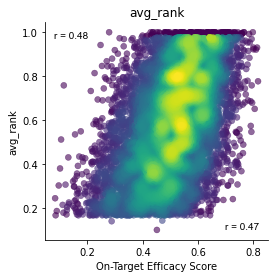

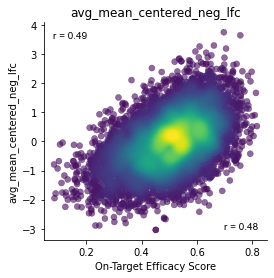

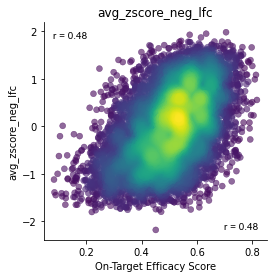

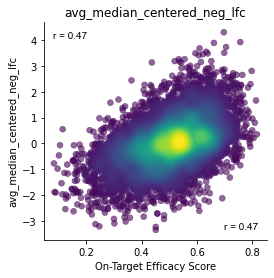

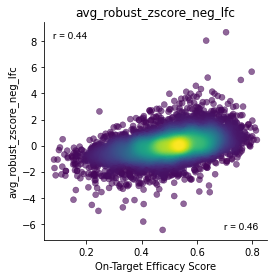

In [11]:
for score in ['avg_rank', 'avg_mean_centered_neg_lfc', 'avg_zscore_neg_lfc',
              'avg_median_centered_neg_lfc', 'avg_robust_zscore_neg_lfc']:
    plt.subplots(figsize=(4,4))
    gpplot.point_densityplot(data=sg_avg_rank[[score, 'On-Target Efficacy Score']].dropna(),
                             y=score, x='On-Target Efficacy Score')
    gpplot.add_correlation(data=sg_avg_rank[[score, 'On-Target Efficacy Score']].dropna(),
                           y=score, x='On-Target Efficacy Score')
    gpplot.add_correlation(data=sg_avg_rank[[score, 'On-Target Efficacy Score']].dropna(),
                           y=score, x='On-Target Efficacy Score', method='spearman', loc='lower right')
    plt.title(score)
    sns.despine()

In [12]:
training_data = sg_avg_rank.drop(['On-Target Efficacy Score', 'avg_rank',
                                  'avg_zscore_neg_lfc', 'avg_median_centered_neg_lfc',
                                  'avg_robust_zscore_neg_lfc'], axis=1)
training_data

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Target Cut %,avg_mean_centered_neg_lfc
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,CPSF6,22.2,-1.139819
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,SKA3,62.3,-0.793055
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AQR,3.8,0.946453
3,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,ZNHIT6,61.7,-0.429590
4,AAAAAGCGAGATACCCGAAA,AAAAAAAAAGCGAGATACCCGAAAAGGCAG,ABCF1,9.4,0.734196
...,...,...,...,...,...
8654,TTTGTGGCAGCGAATCATAA,TGTCTTTGTGGCAGCGAATCATAATGGTTC,UMPS,43.8,-0.927345
8655,TTTGTTAATATCTGCTGAAC,TGAATTTGTTAATATCTGCTGAACAGGAGT,GTF2A1,40.3,-0.382060
8656,TTTGTTAGGATGTGCATTCC,TTTCTTTGTTAGGATGTGCATTCCAGGTAC,NAT10,16.4,-0.927645
8657,TTTGTTAGGTCATCGTATTG,GGTTTTTGTTAGGTCATCGTATTGAGGAAG,RPL4,33.5,-1.425502


In [13]:
lfcs_designs.to_csv('../data/interim/Aguirre2017_condition_lfcs.csv', index=False)
training_data.to_csv('../data/processed/Aguirre2017_activity.csv', index=False)